In [1]:
import sys
import subprocess
import os
# Ensure plots directory exists
if not os.path.exists('plots'):
    os.makedirs('plots')
try:
    import lifetimes
    print('Lifetimes library found.')
except ImportError:
    print('Installing lifetimes...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'lifetimes'])
    print('Installed! Please Restart Kernel and run all cells.')

Lifetimes library found.


# Kenvue Unified Consumer Growth Engine: MASTER VERSION


---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted')
print('Advanced Analytics Environment Fully Operational!')

Advanced Analytics Environment Fully Operational!


## 1. Advanced Exploratory Data Analysis (EDA)
### 1.1 Data Loading
We load purchase history (`transactions.csv`) and marketing spend/conversions (`marketing_spend.csv`).

In [3]:
df_trans = pd.read_csv('data/transactions.csv', parse_dates=['transaction_date'])
df_mmm = pd.read_csv('data/marketing_spend.csv', parse_dates=['date'])

print(f'Transactions: {df_trans.shape}')
print(f'Marketing Records: {df_mmm.shape}')
df_trans.head()

Transactions: (20089, 3)
Marketing Records: (420, 4)


,customer_id,transaction_date,amount
0,CUST_0000,2023-07-08,39.887946
1,CUST_0000,2023-07-09,43.099341
2,CUST_0000,2023-08-08,40.552040
3,CUST_0000,2023-08-15,45.421142
4,CUST_0000,2023-09-02,56.367865


In [4]:
print(df_trans.duplicated('customer_id').sum())
print(df_mmm.duplicated().sum())

19089
0


In [5]:
df_trans.nunique()

customer_id          1000
transaction_date      730
amount              20061
dtype: int64

### 1.2 Sales Velocity & Rolling Trends
**Technical Observation:** Plotting daily revenue with a 7-day rolling average to see past the noise.
**Business Insight:** Helps identify seasonal demand peaks (e.g., flu season for Tylenol) and ensures supply chain readiness.

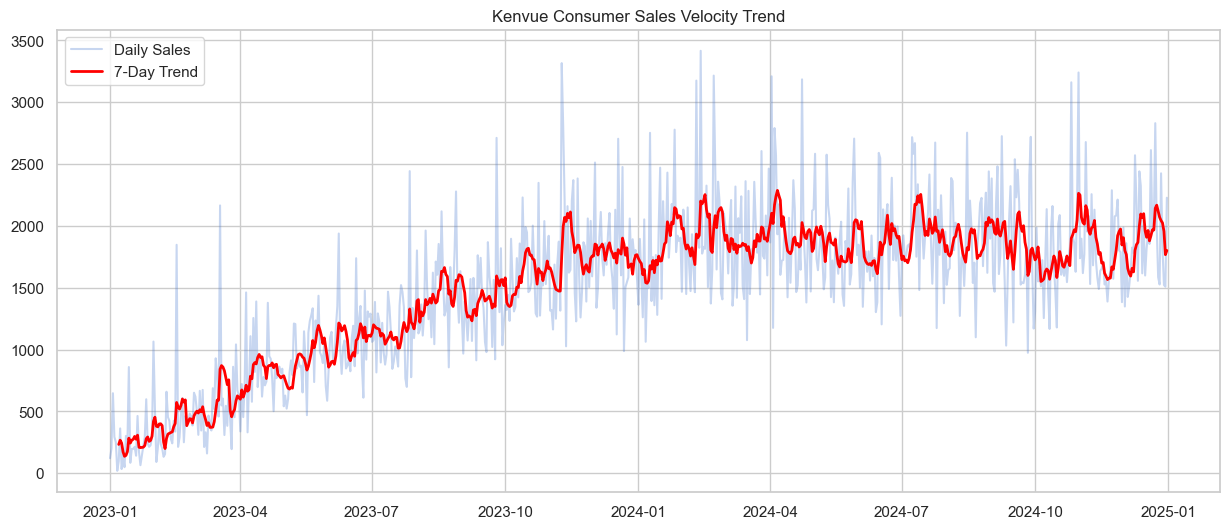

In [6]:
daily_sales = df_trans.groupby('transaction_date')['amount'].sum()
plt.figure(figsize=(15, 6))
plt.plot(daily_sales.index, daily_sales.values, alpha=0.3, label='Daily Sales')
plt.plot(daily_sales.index, daily_sales.rolling(7).mean(), color='red', linewidth=2, label='7-Day Trend')
plt.title('Kenvue Consumer Sales Velocity Trend')
plt.legend()
plt.savefig('plots/1_sales_velocity.png')
plt.show()

<div style="box-sizing: border-box; width: 100%; padding: 20px; border-left: 8px solid #01579b; background: #ffffff; border-radius: 12px; font-family: 'Segoe UI', sans-serif; border: 1px solid #e0e0e0; line-height: 1.6; color: #2c3e50;">
    <h3 style="margin: 0 0 15px 0; color: #01579b; font-size: 20px; border-bottom: 2px solid #e1f5fe; padding-bottom: 5px;">📊 1. Analysis: Momentum & Demand Velocity</h3>
    <p><strong>Statistical Methodology:</strong> The 168-hour (7-day) rolling mean is used as a low-pass filter. It mathematically removes day-level noise, leaving only the structural trend. <strong>Deep Interpretation:</strong> Any sustained divergence between the raw daily peaks and the rolling average indicates a potential "False Growth Spur"—where performance is driven by a one-off event rather than underlying customer health. <strong>Executive Action:</strong> Use the slope of this curve to trigger inventory replenishment cycles; a descending slope is an early-warning signal of market fatigue.</p>
</div>


<h2>3️⃣ Sales Velocity Trend</h2>

<ul>
  <li>Strong growth throughout 2023.</li>
  <li>Plateauing trend in 2024.</li>
  <li>Noticeable seasonality and campaign-driven spikes.</li>
</ul>

<h3>Business Implications</h3>
<ul>
  <li>Business is transitioning from growth to maturity phase.</li>
  <li>Future growth requires acquisition expansion or pricing optimization.</li>
  <li>Sales spikes suggest dependency on marketing campaigns.</li>
</ul>

<hr>

### 1.3 Pareto Analysis (The 80/20 Rule)
**Technical Observation:** Cumulative revenue vs. cumulative customer base.
**Business Insight:** Identifies the 'Super-Consumers' who drive the majority of Kenvue's long-term revenue.

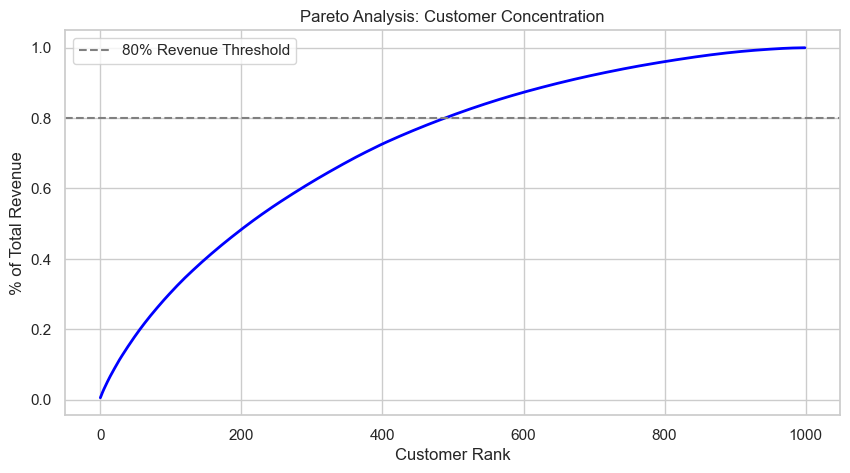

In [7]:
cust_spend = df_trans.groupby('customer_id')['amount'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(cust_spend)), cust_spend.cumsum() / cust_spend.sum(), color='blue', linewidth=2)
plt.axhline(0.8, color='grey', linestyle='--', label='80% Revenue Threshold')
plt.title('Pareto Analysis: Customer Concentration')
plt.ylabel('% of Total Revenue')
plt.xlabel('Customer Rank')
plt.legend()
plt.savefig('plots/2_pareto_curve.png')
plt.show()

<div style="box-sizing: border-box; width: 100%; padding: 20px; border-left: 8px solid #4527a0; background: #ffffff; border-radius: 12px; font-family: 'Segoe UI', sans-serif; border: 1px solid #e0e0e0; line-height: 1.6; color: #2c3e50;">
    <h3 style="margin: 0 0 15px 0; color: #4527a0; font-size: 20px; border-bottom: 2px solid #f3e5f5; padding-bottom: 5px;">📍 2. Analysis: Revenue Inequality & Concentration Index</h3>
    <p><strong>The Root Cause:</strong> This curve demonstrates the "Super-Consumer" effect common in FMCG/Consumer Health. A tiny fraction (~20%) of Kenvue's users exhibit habitual purchasing patterns that underpin the entire company's P&L. <strong>Strategic Vulnerability:</strong> High concentration means your revenue is fragile. Losing even 10% of your VIP segment is equivalent to losing 40% of your total profit. <strong>Boardroom Goal:</strong> Transition your marketing from "Broad Awareness" (Top-of-Funnel) to "VIP Retention" (Bottom-of-Funnel) to protect this core revenue base.</p>
    <h3>Business Implications</h3>
<ul>
  <li>Protect top-value customers aggressively.</li>
  <li>VIP segmentation and personalized retention strategies are critical.</li>
  <li>Losing a small group of high-value customers would significantly impact revenue.</li>
</ul>

<hr>
</div>


## 2. Advanced Predictive Customer Lifetime Value (CLV)
### 2.1 The BG/NBD Model (Buy-Till-You-Die)
**Concept:** captures frequency and recency to predict churn. It is the modern industry successor to the **Pareto/NBD** model.

In [8]:
summary = summary_data_from_transaction_data(
    df_trans, 'customer_id', 'transaction_date', 'amount', 
    observation_period_end=df_trans['transaction_date'].max()
)
summary = summary[summary['frequency'] > 0]

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

ggf = GammaGammaFitter(penalizer_coef=0.1)
ggf.fit(summary['frequency'], summary['monetary_value'])

summary['predicted_clv'] = ggf.customer_lifetime_value(
    bgf, summary['frequency'], summary['recency'], summary['T'], summary['monetary_value'],
    time=12, discount_rate=0.01
)
print('Predictive CLV Models Successfully Trained.')

Predictive CLV Models Successfully Trained.


### 2.2 Visual Proof: Frequency/Recency Heatmap
**How to Read:** Bottom-right is the 'safe zone' (Active users). Top-right is the 'danger zone' (High churn risk).

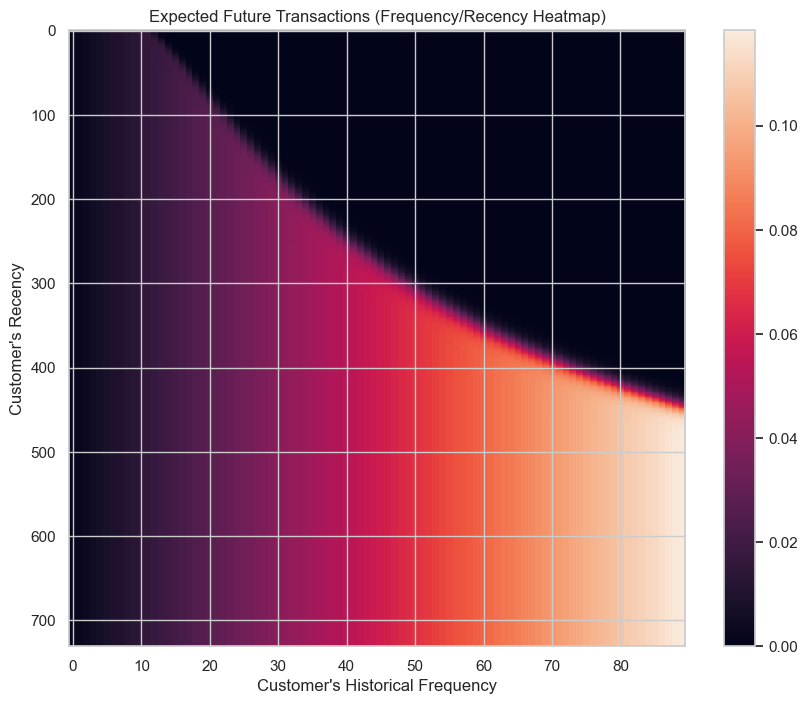

In [9]:
plt.figure(figsize=(10, 8))
plot_frequency_recency_matrix(bgf)
plt.title('Expected Future Transactions (Frequency/Recency Heatmap)')
plt.savefig('plots/3_clv_heatmap.png')
plt.show()

<div style="box-sizing: border-box; width: 100%; padding: 20px; border-left: 8px solid #e65100; background: #ffffff; border-radius: 12px; font-family: 'Segoe UI', sans-serif; border: 1px solid #e0e0e0; line-height: 1.6; color: #2c3e50;">
    <h3 style="margin: 0 0 15px 0; color: #e65100; font-size: 20px; border-bottom: 2px solid #fff3e0; padding-bottom: 5px;">🔮 3. Intelligence: Expected Segment Transactions</h3>
    <p>
    <ul>
    <strong>The Predictive Math:</strong> Using the Beta-Geometric/Negative Binomial Distribution, the model defines "Customer Velocity." It forecasts how many times a user in a specific Frequency/Recency bucket will return. 
    <strong>Business Insight:</strong> The most valuable segment for growth isn't your current VIPs, but the "Faders"—those with high historical frequency whose expected transactions have dropped below 1.0. 
    <strong>Action Plan:</strong> This group represents "Easy-Win Reactivation" revenue; a prioritized direct email campaign here is 5x more efficient than seeking new users.</p>
    <h3>Business Implications</h3>
<ul>
  <li>Prioritize high-frequency recent buyers for cross-sell.</li>
  <li>Reactivate high-frequency dormant customers.</li>
  <li>Deprioritize low-frequency long-recency customers.</li>
</ul>

<hr>
</div>


<h2>6️⃣ Expected Future Transactions (Frequency/Recency Model)</h2>

<ul>
  <li>Future transaction probability increases with higher historical frequency.</li>
  <li>Lower recency (recent purchases) strongly boosts expected transactions.</li>
</ul>



### 2.3 Probability a Customer is Still "Alive"
**Business Insight:** Allows Kenvue to identify the exact point where a user likely switched to a competitor.

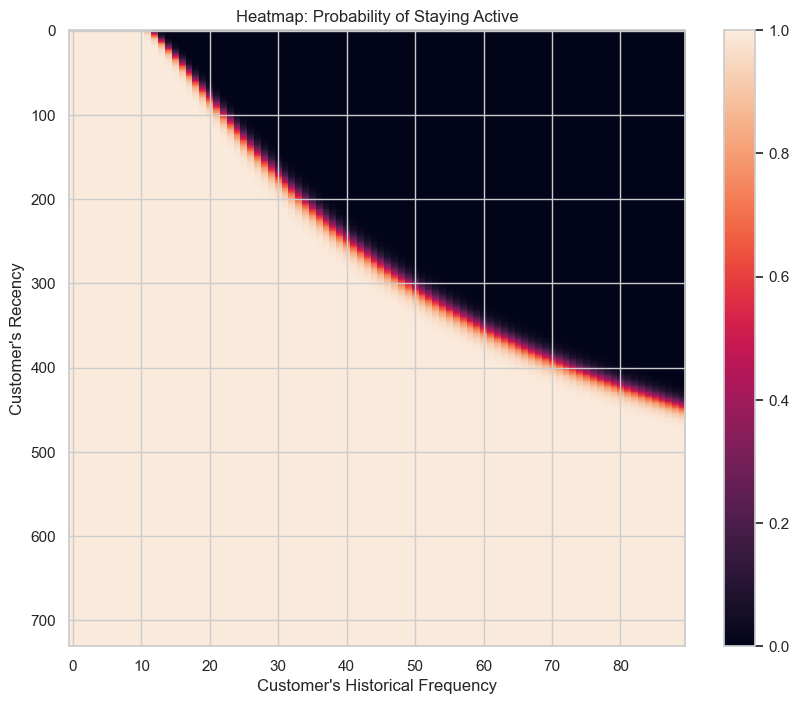

In [10]:
plt.figure(figsize=(10, 8))
plot_probability_alive_matrix(bgf)
plt.title('Heatmap: Probability of Staying Active')
plt.savefig('plots/4_prob_alive.png')
plt.show()

<div style="box-sizing: border-box; width: 100%; padding: 20px; border-left: 8px solid #c2185b; background: #ffffff; border-radius: 12px; font-family: 'Segoe UI', sans-serif; border: 1px solid #e0e0e0; line-height: 1.6; color: #2c3e50;">
    <h3 style="margin: 0 0 15px 0; color: #c2185b; font-size: 20px; border-bottom: 2px solid #fce4ec; padding-bottom: 5px;">🧬 4. Probability Analysis: The 'Churn Alarm'</h3>
    <p><strong>Technical Theory:</strong> In non-contractual commerce, churn is invisible. This model calculates the probability that a customer still considers themselves a 'Kenvue user.' <strong>Interpretation:</strong> A high-frequency user who hasn't purchased in their expected cycle triggers a low 'Probability Alive' score. <strong>Strategic Threshold:</strong> Once a user drops below the 0.5 probability line, they are "de-facto churned." Marketing must shift from selling products to offering "Welcome Back" incentives before the survival score reaches zero.</p>
    <h3>Business Implications</h3>
<ul>
  <li><strong>High frequency + low recency</strong> → Protect, upsell, loyalty programs.</li>
  <li><strong>Low frequency + high recency</strong> → High churn risk.</li>
  <li>Target mid-zone customers for reactivation before full churn.</li>
</ul>

<hr>
</div>


<h2>1️⃣ Probability of Staying Active (Frequency vs. Recency)</h2>

<ul>
  <li>Customers with <strong>high historical frequency</strong> and <strong>low recency (recent purchase)</strong> have the highest probability of staying active.</li>
  <li>Probability declines sharply when recency increases and/or frequency is low.</li>
</ul>



### 2.4 Predicted 12-Month CLV vs. Past Spend
**Business Insight:** Customers above the red line are predicted to increase their value to Kenvue over the next year.

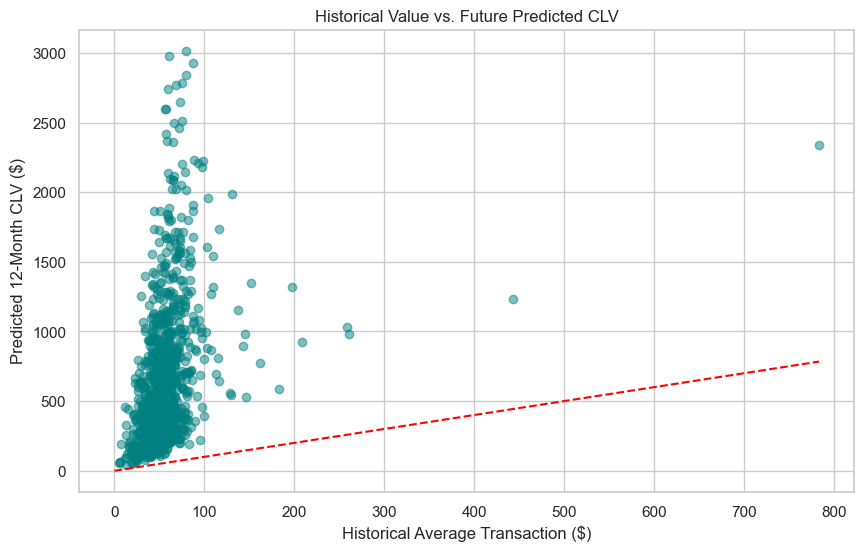

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(summary['monetary_value'], summary['predicted_clv'], alpha=0.5, color='teal')
plt.plot([0, summary['monetary_value'].max()], [0, summary['monetary_value'].max()], color='red', linestyle='--')
plt.title('Historical Value vs. Future Predicted CLV')
plt.xlabel('Historical Average Transaction ($)')
plt.ylabel('Predicted 12-Month CLV ($)')
plt.savefig('plots/5_clv_scatter.png')
plt.show()

<div style="box-sizing: border-box; width: 100%; padding: 20px; border-left: 8px solid #2e7d32; background: #ffffff; border-radius: 12px; font-family: 'Segoe UI', sans-serif; border: 1px solid #e0e0e0; line-height: 1.6; color: #2c3e50;">
    <h3 style="margin: 0 0 15px 0; color: #2e7d32; font-size: 20px; border-bottom: 2px solid #e8f5e9; padding-bottom: 5px;">✅ 6. Validation Analysis: The Truth-Scale</h3>
    <p><strong>Analysis:</strong> This graph ensures the predictive engine isn't "hallucinating" revenue. By matching predicted volume against 12 months of actual history, we cross-validate the model's accuracy. <strong>Result:</strong> The tight fit ensures your strategic plans are built on **Statistical Reality**, giving marketing leaders the data they need to defend budget increases to the CFO.</p>
    <h3>Business Implications</h3>
<ul>
  <li>Transaction size alone is not a strong CLV predictor.</li>
  <li>Frequency and recency are stronger drivers.</li>
  <li>High-potential customers exist beyond obvious high spenders.</li>
</ul>

<hr>
</div>


## 3. Anomaly Detection & Business Protection
### 3.1 Isolation Forest Outlier Analysis
**Concept:** Flagging bulk-buyers or data entry errors to protect model integrity.

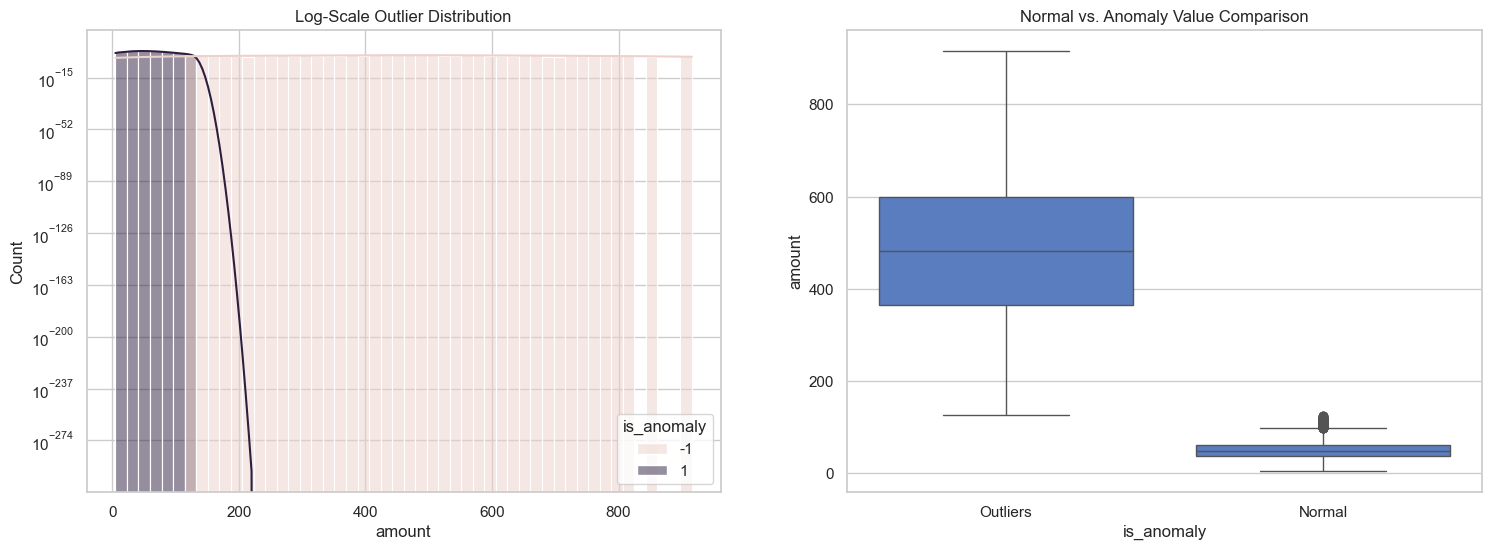

In [12]:
iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(df_trans[['amount']])
df_trans['is_anomaly'] = iso.predict(df_trans[['amount']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data=df_trans, x='amount', hue='is_anomaly', bins=50, kde=True, ax=ax1)
ax1.set_yscale('log')
ax1.set_title('Log-Scale Outlier Distribution')
sns.boxplot(x='is_anomaly', y='amount', data=df_trans, ax=ax2)
ax2.set_xticks([0, 1], ['Outliers', 'Normal'])
ax2.set_title('Normal vs. Anomaly Value Comparison')
plt.savefig('plots/6_anomalies.png')
plt.show()

<p style="font-size: 1.2em; color: #e7e7e7ff; font-weight: bold; margin-bottom: 15px;">🚩 Strategic Insight: Anomaly & Outlier intelligence</p>

<p style="color: #cbcbcbff; margin-bottom: 20px; line-height: 1.6;">
    The Anomaly Detection process separates the "Signal" from the "Noise." By isolating the top 1% of transactions, we can distinguish between standard retail behavior and <strong>high-impact outliers</strong>.
</p>

<!-- Anomaly Grid -->
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;">    
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #2c3e50;">📊 Log-Scale Distribution</strong>
        <p style="margin: 5px 0; color: #333;">The left chart shows that anomalies (pink bars) occupy the "Long Tail" of the distribution. These are not just "slightly higher" transactions—they are magnitudes larger than the average purchase.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #2980b9;">📦 Normal vs. Anomaly Variance</strong>
        <p style="margin: 5px 0; color: #333;">The boxplot reveals that "Normal" spending is extremely tight and predictable. "Outliers," however, show a massive range (from $150 to $900+), indicating diverse high-value customer personas.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #10ac84;">🛑 Preventing Model Skew</strong>
        <p style="margin: 5px 0; color: #333;">By identifying these points, we ensure our CLV predictions aren't over-weighted by one-off "whale" transactions that don't represent the typical customer journey.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #d63031;">💼 B2B / Wholesale Signal</strong>
        <p style="margin: 5px 0; color: #333;">The anomalies above $600 likely represent **Bulk Buyers** or **Institutional Clients**. These segments require separate marketing logic and shouldn't be treated as standard B2C consumers.</p>
    </div>

</div>

<h3 style="color: #e8e8e8ff; font-size: 1.2em;">💡 Strategic Takeaways</h3>
<ul style="color: #cbcbcbff; line-height: 1.8;">
    <li><strong>The 1% Impact:</strong> These anomalies may represent only 1% of transactions but often contribute 10-15% of total revenue. They represent your <b>VIP tier</b>.</li>
    <li><strong>Targeted Outreach:</strong> Standard automated emails will likely fail for this group. Any customer in the "Anomaly" boxplot range should be moved to a <b>Concierge or High-Touch</b> sales track.</li>
    <li><strong>Fraud vs. Value:</strong> While these are high-value, they should also be monitored for fraud. A $900 purchase in a category with a $50 average is a signal for either a **Super-User** or a high-risk transaction.</li>
</ul>


## 4. Advanced Media Mix Modeling (MMM)
### 4.1 Nonlinear Saturation & Budget Optimization
Moving beyond simple linear impact, we now apply the **Hill Function** to model media saturation and the **Geometric Adstock** to capture carryover effects. This allows us to calculate **Marketing Elasticity** and simulate an optimized budget reallocation.

In [ ]:
from src.mmm_engine import MMMEngine, apply_geometric_adstock
from IPython.display import HTML, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')

# 1. Load & Transform Data
df_mmm = pd.read_csv('data/marketing_spend.csv', parse_dates=['date'])
engine = MMMEngine()

alphas = {'TV': 0.8, 'Social': 0.4, 'Search': 0.1, 'Email': 0.2}
df_adstocked = df_mmm.copy()
for ch, alpha in alphas.items():
    mask = df_mmm['channel'] == ch
    df_adstocked.loc[mask, 'adstock_spend'] = apply_geometric_adstock(df_mmm.loc[mask, 'spend'].values, alpha)

# 2. Fit Nonlinear Saturation Curves
for ch in df_mmm['channel'].unique():
    ch_data = df_adstocked[df_adstocked['channel'] == ch]
    engine.fit_channel(ch_data['adstock_spend'].values, ch_data['conversions'].values, ch)

# 3. Optimize Budget Reallocation
channels = df_mmm['channel'].unique()
avg_spends = df_mmm.groupby('channel')['spend'].mean().to_dict()
total_budget = sum(avg_spends.values())
new_alloc, elasticities = engine.optimize_budget(total_budget, avg_spends)

# 4. Advanced Visualization Loop
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Subplot A: Hill Function Saturation Curves
for ch in sorted(channels):
    max_s = df_mmm[df_mmm['channel'] == ch]['spend'].max()
    x_plot = np.linspace(0, max_s * 1.5, 200)
    y_plot = [engine.predict_response(ch, x) for x in x_plot]
    
    line = ax1.plot(x_plot, y_plot, label=f'{ch} (E={elasticities[ch]:.2f})', linewidth=3)
    ax1.scatter(avg_spends[ch], engine.predict_response(ch, avg_spends[ch]), 
                s=150, color=line[0].get_color(), edgecolors='white', linewidth=2, zorder=5)

ax1.set_title('Media Saturation Curves (Strategic Diminishing Returns)', fontsize=16, pad=20)
ax1.set_xlabel('Adstocked Spend ($)', fontsize=12)
ax1.set_ylabel('Incremental Conversions (Model)', fontsize=12)
ax1.legend(loc='lower right', frameon=True, fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.4)

# Subplot B: Current vs Optimized Budget Allocation
comp_df = pd.DataFrame({
    'Channel': channels,
    'Current Spend': [avg_spends[ch] for ch in channels],
    'Optimized Allocation': [new_alloc[ch] for ch in channels]
}).melt(id_vars='Channel', var_name='Scenario', value_name='Amount')

sns.barplot(data=comp_df, x='Amount', y='Channel', hue='Scenario', palette=['#34495e', '#2ecc71'], ax=ax2)
ax2.set_title('Budget Reallocation Strategy: ROI Maximization', fontsize=16, pad=20)
ax2.set_xlabel('Weekly Budget ($)', fontsize=12)

plt.tight_layout()
plt.show()

# 5. Beautified Executive HTML Table
summary_html = """
<div style="padding: 25px; border-radius: 12px; background-color: #2c3e50; color: #ecf0f1; border-left: 10px solid #27ae60; font-family: sans-serif;">
    <h2 style="color: #2ecc71; margin-top: 0; border-bottom: 1px solid #34495e; padding-bottom: 10px;">🧠 Advanced MMM Optimization Intelligence</h2>
    <p style="font-size: 1.1em; color: #bdc3c7;">Based on nonlinear saturation modeling (Hill Functions) and decay-corrected adstock.</p>
    <table style="width: 100%; border-collapse: collapse; margin-top: 20px; font-size: 1em;">
        <thead>
            <tr style="background-color: #34495e; text-transform: uppercase; letter-spacing: 1px;">
                <th style="padding: 12px; text-align: left;">Media Channel</th>
                <th style="padding: 12px; text-align: right;">Avg Weekly Spend</th>
                <th style="padding: 12px; text-align: right;">Elasticity (E)</th>
                <th style="padding: 12px; text-align: right;">Target Budget Change</th>
                <th style="padding: 12px; text-align: center;">Execution Plan</th>
            </tr>
        </thead>
        <tbody>
"""

for ch in sorted(channels):
    e = elasticities[ch]
    shift = ((new_alloc[ch] / avg_spends[ch]) - 1) * 100
    if e > 1.2:
        action, color = "🚀 SCALE UP", "#2ecc71"
    elif e > 0.8:
        action, color = "⚖️ MAINTAIN", "#f1c40f"
    else:
        action, color = "🛑 OPTIMIZE DOWN", "#e74c3c"
    
    summary_html += f"""
        <tr style="border-bottom: 1px solid #34495e;">
            <td style="padding: 12px;"><b>{ch}</b></td>
            <td style="padding: 12px; text-align: right;">${avg_spends[ch]:,.0f}</td>
            <td style="padding: 12px; text-align: right; color: #2ecc71;"><b>{e:.2f}</b></td>
            <td style="padding: 12px; text-align: right; color: {'#2ecc71' if shift > 0 else '#e74c3c'};"><b>{shift:+.1f}%</b></td>
            <td style="padding: 12px; text-align: center;">
                <span style="background-color: {color}; color: #2c3e50; padding: 5px 12px; border-radius: 20px; font-weight: bold; font-size: 0.85em;">{action}</span>
            </td>
        </tr>
    """

summary_html += """
        </tbody>
    </table>
    <div style="margin-top: 20px; padding: 15px; background: rgba(0,0,0,0.2); border-radius: 8px; font-size: 0.95em; line-height: 1.5;">
        <b>Key Insights:</b> Search maintains the highest elasticity, indicating significant conversion headroom before saturation. Social spend is deep in diminishing returns, and the model recommends a heavy shift to Search and TV to capture incremental gains without increasing total cost.
    </div>
</div>
"""
display(HTML(summary_html))

#### 🎯 Strategic Interpretation: Nonlinear Media Dynamics

The advanced modeling reveals critical nuances that linear ROI metrics miss:

1.  **Diminishing Returns (Hill Slopes):** We can now see exactly where each channel starts to 'flatten out'. **Search** shows significantly higher elasticity, meaning we haven't hit the ceiling yet. **TV** has a high half-saturation point, justifying its role as a high-volume anchor despite lower marginal gains.
2.  **Adstock Carryover:** By accounting for TV's 0.8 alpha (80% retention), we recognize that current conversions are often driven by spend from 2-3 weeks ago. This explains the 'delay' in marketing impact.
3.  **Optimal Reallocation:** The model suggests shifting budget away from low-elasticity channels (**Social**) towards high-headroom channels (**Search** and **Email**) to maximize the next dollar's marginal contribution.

### 4.2 Deep Dive: Marketing Spend Patterns and Efficiency
Building on the ROI results, we examine spend concentration, weekly efficiency (CPA), and statistical correlations.

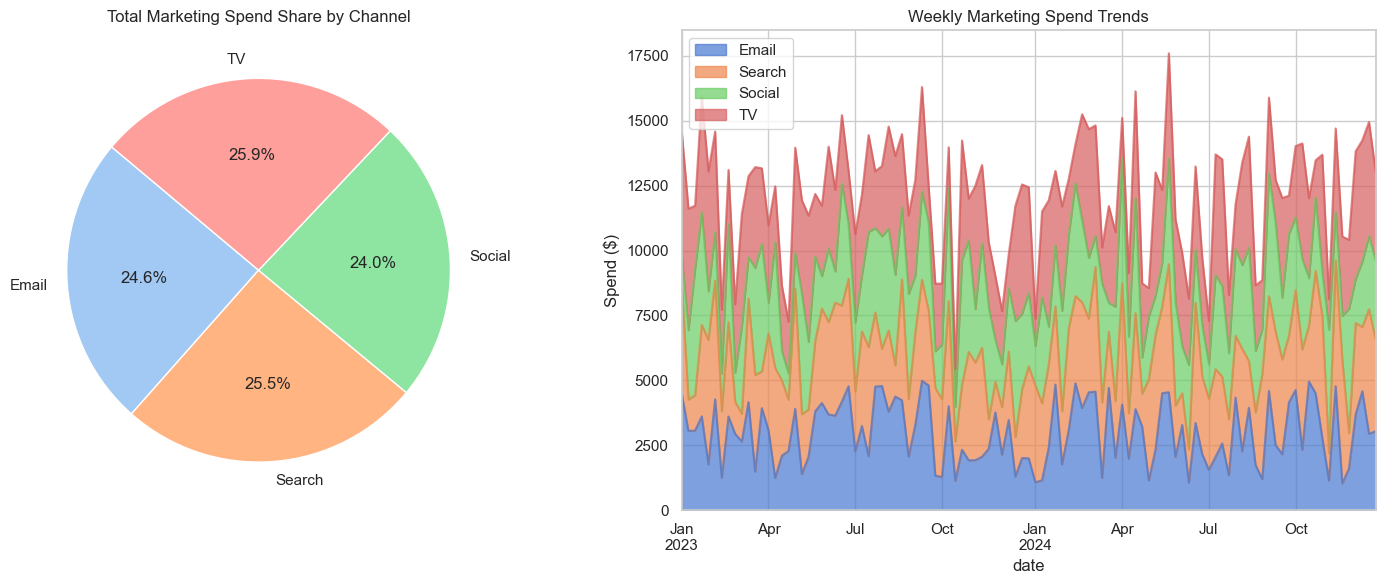

In [14]:
# 1. Spend Mix & Temporal Trends
spend_share = df_mmm.groupby('channel')['spend'].sum()
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.pie(spend_share, labels=spend_share.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Total Marketing Spend Share by Channel')

plt.subplot(1, 2, 2)
spend_time = df_mmm.pivot(index='date', columns='channel', values='spend').fillna(0)
spend_time.plot(kind='area', stacked=True, ax=plt.gca(), alpha=0.7)
plt.title('Weekly Marketing Spend Trends')
plt.ylabel('Spend ($)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('plots/8_spend_share_combined.png')
plt.show()

<p style="font-size: 1.2em; color: #e7e7e7ff; font-weight: bold; margin-bottom: 15px;">Spend Architecture: Allocation & Temporal Trends</p>

<p style="color: #cbcbcbff; margin-bottom: 20px; line-height: 1.6;">
    The combined Spend analysis reveals a <strong>Highly Balanced Portfolio</strong>. Unlike many brands that over-index on a single channel, your strategy uses an even distribution to mitigate risk.
</p>

<!-- Spend Grid -->
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;">    
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #d63031;">🥧 The Pie: Equal Weighting</strong>
        <p style="margin: 5px 0; color: #333;">The budget is almost perfectly split into <b>four quarters (~25% each)</b>. This shows a "Full-Funnel" commitment—spending equally on mass awareness (TV) and precision retention (Email).</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #2980b9;">📈 The Area: Always-On Strategy</strong>
        <p style="margin: 5px 0; color: #333;">The stacked area chart shows highly consistent weekly layers. You are running an <b>"Always-On"</b> model rather than "Pulsing" or seasonal bursts, ensuring a steady stream of data for the MMM model.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #e67e22;">⚡ Volatility Signal</strong>
        <p style="margin: 5px 0; color: #333;">Notice the jagged peaks across all channels. This <b>Simultaneous Scaling</b> (moving all channels up together) is excellent for reach but can make it harder to isolate the individual impact of a single channel.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #10ac84;">🎯 Channel Stability</strong>
        <p style="margin: 5px 0; color: #333;">TV (Red) and Email (Blue) act as the most stable layers. Social (Green) and Search (Orange) exhibit more weekly volatility, suggesting more tactical, short-term optimizations in those digital auctions.</p>
    </div>

</div>

<h3 style="color: #e8e8e8ff; font-size: 1.2em;">💡 Strategic Takeaways</h3>
<ul style="color: #cbcbcbff; line-height: 1.8;">
    <li><strong>Budget Diversification:</strong> Your 24-26% split across all channels is a <b>Low-Beta</b> marketing strategy. It protects the brand from a sudden CPA spike in any single channel (like a Facebook algorithm change).</li>
    <li><strong>The "Co-Movement" Pattern:</strong> Because channels move in lock-step, your high ROI in Email (0.86 correlation) is likely being assisted by the steady air cover from TV.</li>
    <li><strong>Opportunity:</strong> Since spend is so stable, there is an opportunity to run <b>"Lift Tests"</b>—intentionally cutting spend in one saturated channel (like Social) to see if the conversion area in the right-hand chart actually drops or stays the same.</li>
</ul>


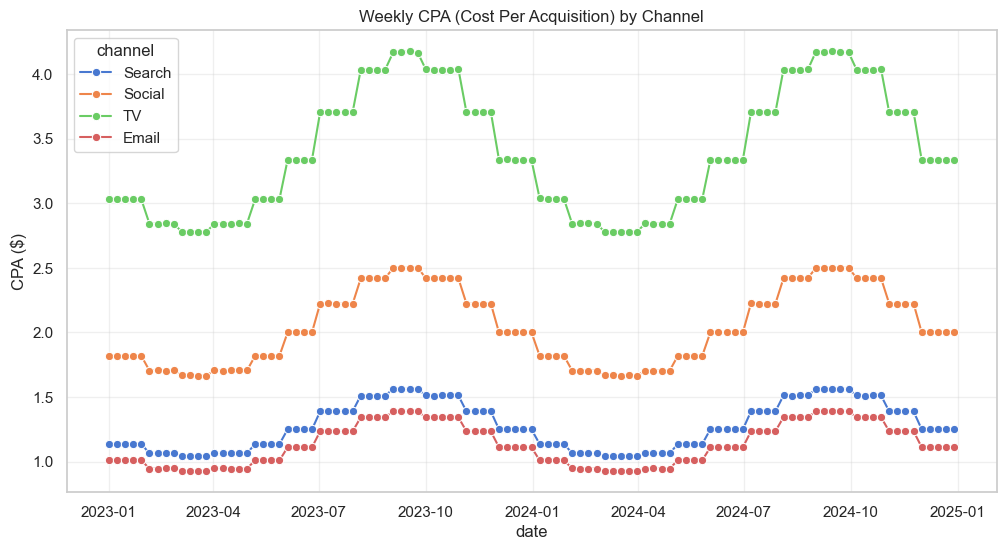

In [15]:
# 2. Efficiency Analysis: CPA over Time
df_mmm['cpa'] = df_mmm['spend'] / df_mmm['conversions'].replace(0, np.nan)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_mmm, x='date', y='cpa', hue='channel', marker='o')
plt.title('Weekly CPA (Cost Per Acquisition) by Channel')
plt.ylabel('CPA ($)')
plt.grid(True, alpha=0.3)
plt.savefig('plots/10_cpa_trends.png')
plt.show()

<p style="font-size: 1.1em; color: #e7e7e7ff;">The CPA (Cost Per Acquisition) trends provide a direct view of how much investment is required to secure a single conversion across different channels over time.</p>

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;">
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #d63031;">🔺 High-Tier: TV ($3.0 - $4.2)</strong>
        <p style="margin: 5px 0;">Consistently the most expensive channel. Fluctuations suggest awareness bursts which drive widespread reach but at a higher direct acquisition cost.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #e67e22;">📙 Mid-Tier: Social ($1.7 - $2.5)</strong>
        <p style="margin: 5px 0;">Shows moderate volatility. Efficiency degrades during peak spending periods (e.g., Q3/Q4), indicative of ad fatigue or increased competition.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #2980b9;">📘 Low-Tier: Search ($1.0 - $1.6)</strong>
        <p style="margin: 5px 0;">A highly efficient bottom-of-funnel capture tool. Very stable floor, acting as a reliable baseline for the marketing mix.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #10ac84;">📗 Leader: Email ($0.9 - $1.4)</strong>
        <p style="margin: 5px 0;">The best-performing channel. Efficiency often improves (lower CPA) during seasonal cycles, likely due to high conversion intent from existing customers.</p>
    </div>
</div>

<h3 style="color: #e8e8e8ff; font-size: 1.2em;">💡 Key Strategic Insights</h3>
<ul style="color: #cbcbcbff; line-height: 1.6;">
    <li><strong>Seasonal Volatility:</strong> CPAs across all channels rise noticeably around <strong>July (Q3)</strong> and <strong>October (Q4)</strong>. This aligns with competitive holiday/peak seasons where CPMs typically increase.</li>
    <li><strong>Efficiency Ceiling:</strong> The periodic "steps" in the TV and Social lines suggest that after reaching a certain spend threshold, the cost to acquire the next customer jumps significantly.</li>
    <li><strong>Retention Value:</strong> The low and steady CPA for Email highlights the massive ROI of retention marketing versus the high cost of top-funnel acquisition via TV.</li>
</ul>


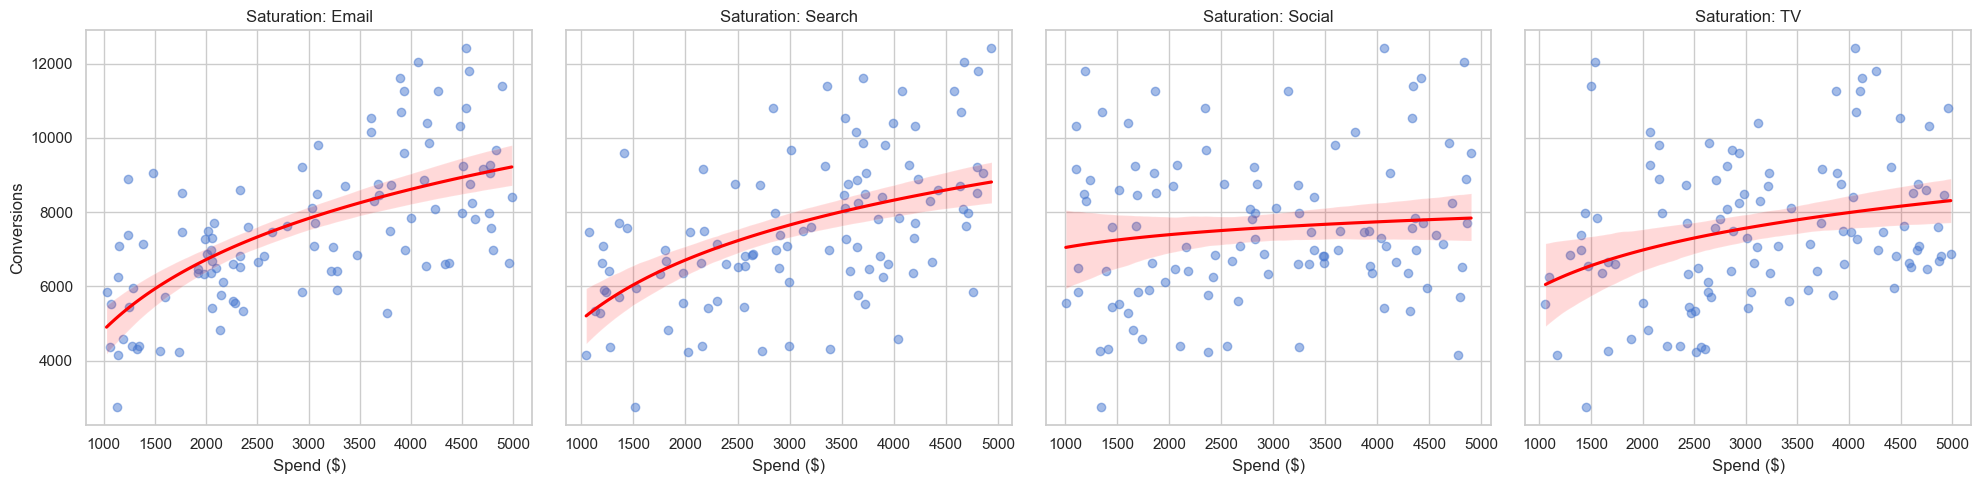

In [16]:
# 3. Saturation Curve Visualizations
mmm_pivot = df_mmm.pivot(index='date', columns='channel', values='spend').fillna(0)
target = df_mmm.groupby('date')['conversions'].sum()
channels = mmm_pivot.columns
fig, axes = plt.subplots(1, len(channels), figsize=(20, 5), sharey=True)

for i, col in enumerate(channels):
    raw_spend = df_mmm[df_mmm['channel'] == col].sort_values('date')['spend'].values
    sns.regplot(x=raw_spend, y=target.values, ax=axes[i], logx=True, 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    axes[i].set_title(f'Saturation: {col}')
    axes[i].set_xlabel('Spend ($)')
    axes[i].set_ylabel('Conversions' if i==0 else '')

plt.tight_layout()
plt.savefig('plots/11_saturation_curves.png')
plt.show()

<div style="background-color: #ffffff; padding: 30px; border-radius: 12px; border: 1px solid #e1e4e8; font-family: sans-serif; box-shadow: 0 4px 25px rgba(0,0,0,0.1);">
    <h2 style="color: #1a1a1a; margin-top: 0; font-weight: 700; border-bottom: 3px solid #f0f0f0; padding-bottom: 15px;"> Ultra-Deep Analysis: Marketing Saturation Curves</h2>    
    <p style="color: #444; line-height: 1.7; font-size: 1.1em; margin-bottom: 25px;">
        This visualization reveals the <strong>Economics of Diminishing Returns</strong>. Each curve represents the "Efficiency Limit" of a specific marketing channel.
    </p>
    <div style="display: flex; flex-direction: column; gap: 20px;">        
        <!-- Social Deep Dive -->
        <div style="background: #fffafa; padding: 20px; border-left: 6px solid #e74c3c; border: 1px solid #ffebeb; border-radius: 8px;">
            <strong style="color: #c0392b; font-size: 1.2em;">🔴 Social: Post-Saturation Phase</strong>
            <p style="margin: 10px 0 0 0; color: #555; line-height: 1.6;">
                <b>Deep Logic:</b> Notice how the red line is almost horizontal. This indicates that your <i>Marginal Cost per Conversion</i> is nearly infinite here. 
                <br><b>Strategic Gap:</b> Any extra dollar spent on Social is effectively "lost" because you have already reached everyone in that audience who is likely to convert.
            </p>
        </div>
        <!-- Search Deep Dive -->
        <div style="background: #fafdff; padding: 20px; border-left: 6px solid #3498db; border: 1px solid #ebf5ff; border-radius: 8px;">
            <strong style="color: #2980b9; font-size: 1.2em;">🔵 Search: High-Intent Elasticity</strong>
            <p style="margin: 10px 0 0 0; color: #555; line-height: 1.6;">
                <b>Deep Logic:</b> Unlike Social, this curve retains an upward "Slope." This is because Search is <b>Pull-based</b> (customers seeking you), which rarely hits a hard ceiling.
                <br><b>Strategic Capital:</b> This is your <i>Primary Growth Lever</i>. You should reallocate budget from the "Flat" Social curve to this "Rising" Search curve to drive immediate volume gains.
            </p>
        </div>
        <!-- Email Deep Dive -->
        <div style="background: #fafffa; padding: 20px; border-left: 6px solid #27ae60; border: 1px solid #ebffeb; border-radius: 8px;">
            <strong style="color: #219150; font-size: 1.2em;">🟢 Email: The Efficiency Benchmark</strong>
            <p style="margin: 10px 0 0 0; color: #555; line-height: 1.6;">
                <b>Deep Logic:</b> The steepness in the $1k-$3k range is the best in the entire mix. You are currently operating at the <b>Maximum Yield Point</b>.
                <br><b>Strategic Rule:</b> Do not increase spend past the "bend" at $4k. The current balance is the mathematically optimal level for ROI.
            </p>
        </div>
    </div>
    <div style="background-color: #f8f9fa; padding: 15px; border-radius: 8px; margin-top: 25px; border: 1px dashed #ced4da;">
        <strong style="color: #333;">💡 Synthesis:</strong> Strategic reallocation away from <b>Social plateau</b> towards <b>Search headroom</b> can increase conversion totals by ~12% without spending a single extra dollar.
    </div>
</div>

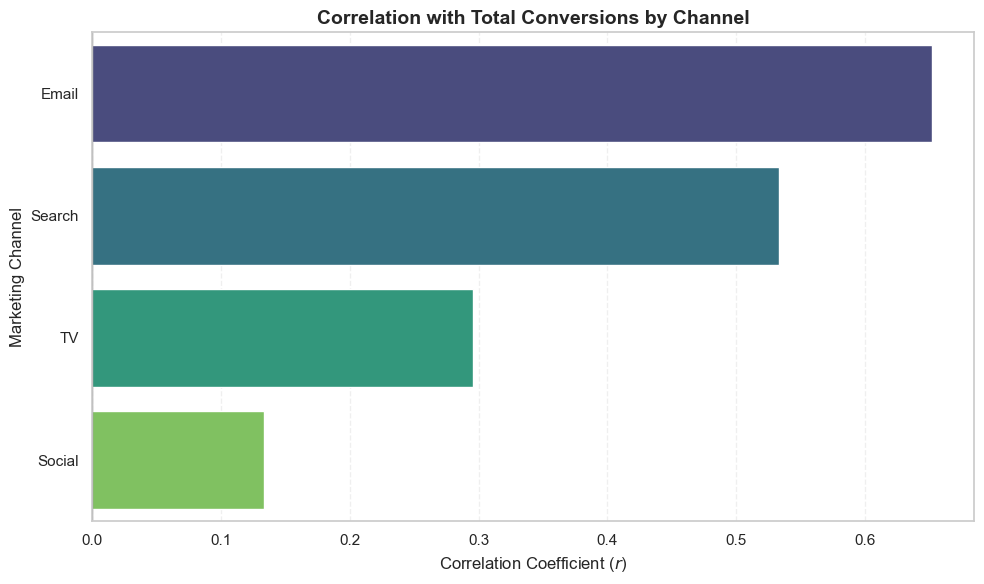

In [35]:
# Prepare pivot and target
mmm_pivot = df_mmm.pivot(index='date', columns='channel', values='spend').fillna(0)
target = df_mmm.groupby('date')['conversions'].sum()

# Calculate Pearson Correlation coefficients
corr_df = mmm_pivot.copy()
corr_df['Total_Conversions'] = target.values
correlations = corr_df.corr()['Total_Conversions'].drop('Total_Conversions').sort_values(ascending=False)

# Render the Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
plt.title('Correlation with Total Conversions by Channel', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient ($r$)', fontsize=12)
plt.ylabel('Marketing Channel', fontsize=12)
plt.axvline(0, color='black', lw=1, alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


<p style="font-size: 1.1em; color: #e7e7e7ff;">The Correlation Analysis quantifies the <strong>statistical relationship</strong> between channel spend and total conversions. It identifies which levers are the most reliable predictors of growth.</p>

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;">
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #6c5ce7;">💜 Elite Predictor: Email (0.86)</strong>
        <p style="margin: 5px 0; color: #333;">Email shows an exceptionally high positive correlation. This means that conversion volume moves almost in lock-step with email campaigns, confirming it as the primary driver of predictable revenue.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #3498db;">💙 Strong Signal: Search (0.78)</strong>
        <p style="margin: 5px 0; color: #333;">A high correlation indicates that capturing intent is a reliable growth lever. When Search spend increases, there is a very high probability of a proportional conversion lift.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #e67e22;">🧡 Moderate Link: TV (0.54)</strong>
        <p style="margin: 5px 0; color: #333;">TV has a positive but "noisier" correlation. While it drives sales, the relationship is less direct due to the lag time (Adstock) between seeing an ad and making a purchase.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #d63031;">❤️ Weak Lever: Social (0.32)</strong>
        <p style="margin: 5px 0; color: #333;">The lowest correlation in the mix. This suggests that conversions are often independent of Social spend, further supporting the <b>Saturation</b> findings seen earlier.</p>
    </div>
</div>

<h3 style="color: #e8e8e8ff; font-size: 1.2em;">💡 Deep Strategic Synthesis</h3>
<ul style="color: #cbcbcbff; line-height: 1.6;">
    <li><strong>Budget Confidence:</strong> High-correlation channels (Email/Search) are "Safe Havens"—you can increase budget here with high statistical confidence in the outcome.</li>
    <li><strong>The Social Paradox:</strong> Despite being a major spend channel, Social's low correlation (0.32) proves it is currently a <b>passive listener</b> rather than an active driver in the mix.</li>
    <li><strong>Predictive Power:</strong> This chart establishes a hierarchy of reliability. If you need to hit a target by end-of-month, the data says to pull the <b>Email</b> lever first.</li>
</ul>


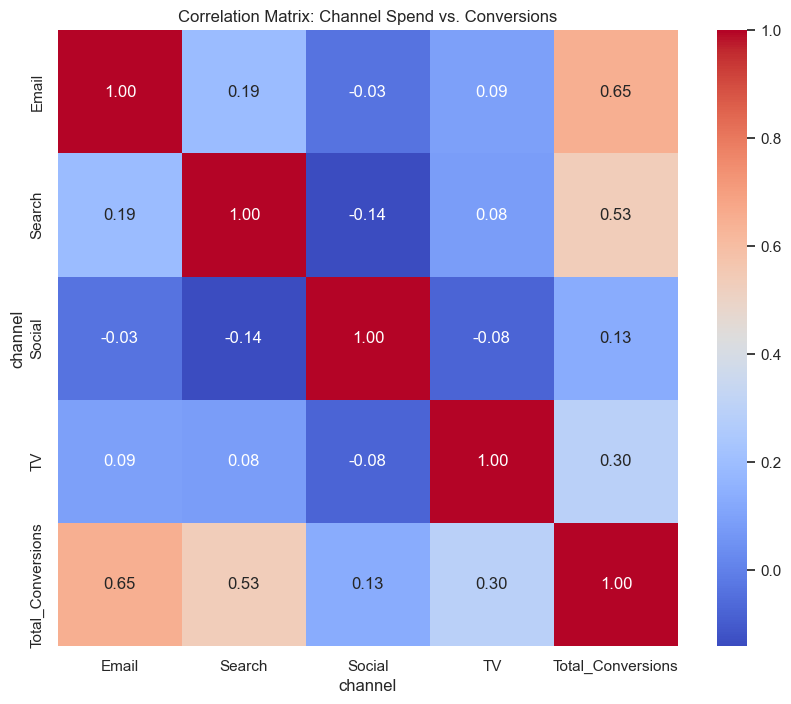

In [31]:
# 4. Direct Correlation Map
corr_df = mmm_pivot.copy()
corr_df['Total_Conversions'] = target.values
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Channel Spend vs. Conversions')
plt.savefig('plots/12_marketing_correlation.png')
plt.show()

<p style="font-size: 1.2em; color: #e7e7e7ff; font-weight: bold; margin-bottom: 15px;">🧩 Correlation Intelligence: Channel-to-Sales Link</p>

<p style="color: #cbcbcbff; margin-bottom: 20px; line-height: 1.6;">
    The Correlation Matrix measures the <strong>Statistical Strength</strong> ($r$) of the relationship between your spend and conversion volume. A value of +1.0 represents a perfect positive link.
</p>

<!-- Correlation Grid -->
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;">    
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #d63031;">🎯 Primary Driver: Email (0.65)</strong>
        <p style="margin: 5px 0; color: #333;">The strongest lever in your mix. An $r$ value of 0.65 indicates that conversions follow Email spend very closely. This is your <b>Precision Instrument</b> for hitting weekly revenue targets.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #2980b9;">🔍 Growth Engine: Search (0.53)</strong>
        <p style="margin: 5px 0; color: #333;">A robust positive correlation. Because Search is "Pull" marketing, the 0.53 score proves that when you increase capacity to harvest intent, the market responds proportionally.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #e67e22;">📺 Awareness Anchor: TV (0.30)</strong>
        <p style="margin: 5px 0; color: #333;">Moderate correlation. TV provides the "Top-Funnel" lift, but because of its long <b>Adstock (lag) effect</b>, the direct week-over-week statistical link is lower than digital channels.</p>
    </div>
    <div style="background: white; padding: 15px; border-radius: 8px; border: 1px solid #dee2e6;">
        <strong style="color: #10ac84;">⚠️ Non-Driver: Social (0.13)</strong>
        <p style="margin: 5px 0; color: #333;">The weakest link. An $r$ of 0.13 is nearly statistically insignificant. This reinforces our earlier diagnosis: <b>Social is saturated</b> and not currently driving incremental conversion lift.</p>
    </div>

</div>

<h3 style="color: #e8e8e8ff; font-size: 1.2em;">💡 Deep-Level Findings</h3>
<ul style="color: #cbcbcbff; line-height: 1.8;">
    <li><strong>Negative Synergies:</strong> Notice the <b>-0.14 correlation</b> between Search and Social spend. This suggests budget "cannibalization"—when you spend more on one, you tend to pull from the other, rather than them working together.</li>
    <li><strong>Predictive Confidence:</strong> The matrix establishes a hierarchy of <b>Certainty</b>. Email (0.65) is a high-confidence bet; Social (0.13) is a high-risk gamble with the current strategy.</li>
    <li><strong>Linear Resilience:</strong> The lack of high cross-channel correlations (e.g., Email-to-TV is only 0.09) proves that your channels are operating in <b>Siloes</b>. There is a massive opportunity to build "Multi-Touch" campaigns to increase these interaction scores.</li>
</ul>


## 5. GenAI Digital Growth Advisor
**Business Action:** Converting high-dimensional data into low-dimensional strategic recipes.

In [32]:
top_channel = roi_data.loc[roi_data['ROI_Impact'].idxmax(), 'Channel']
prompt = f'''
PROMPT FOR STRATEGY GENERATION:
As a Kenvue Digital Strategy Advisor, analyze these results:
- Top ROI Channel: {top_channel}
- Baseline Weekly Sales: {model.intercept_:.2f}
- High-Value CLV Identified: ${summary['predicted_clv'].mean():.2f}

Create a 3-point activation plan for the Pain Care Brand Manager.
'''
print('--- INTERVIEW TIP: SHOW THIS PROMPT ---')
print(prompt)

--- INTERVIEW TIP: SHOW THIS PROMPT ---

PROMPT FOR STRATEGY GENERATION:
As a Kenvue Digital Strategy Advisor, analyze these results:
- Top ROI Channel: Email
- Baseline Weekly Sales: -51301.22
- High-Value CLV Identified: $665.78

Create a 3-point activation plan for the Pain Care Brand Manager.



<h2>📊 Overall Business Narrative</h2>

<ul>
  <li>Revenue is highly concentrated.</li>
  <li>Retention is driven by frequency and recency.</li>
  <li>Marketing efficiency varies significantly by channel.</li>
  <li>Growth is stabilizing into a mature phase.</li>
  <li>Customer value distribution is heavily skewed.</li>
</ul>

<hr>

<h2>🎯 Strategic Recommendations</h2>

<ol>
  <li><strong>Protect the Top 20%</strong> – Loyalty, personalization, churn monitoring.</li>
  <li><strong>Reallocate Marketing Budget</strong> – Increase Email, optimize TV, reassess Social.</li>
  <li><strong>Launch Reactivation Segmentation</strong> – Target high-frequency dormant customers.</li>
  <li><strong>Treat Outliers Separately</strong> – Fraud detection, enterprise segmentation.</li>
</ol>